In [5]:
from calibration import master_bias, master_flat
import glob
import os

master_bias('C:/Users/truji/Desktop/MIT_F25/12_411/data/20260115/masters', 
            glob.glob(os.path.join('C:/Users/truji/Desktop/MIT_F25/12_411/data/20260115/biases', '*.fits')),
            "20260115_masterBIAS_SDSSr"
)

master_flat('C:/Users/truji/Desktop/MIT_F25/12_411/data/20260115/masters',
            glob.glob(os.path.join('C:/Users/truji/Desktop/MIT_F25/12_411/data/20260115/flats', '*.fits')),
            'C:/Users/truji/Desktop/MIT_F25/12_411/data/20260115/masters/20260115_masterBIAS_SDSSr.fits',
            "20260115_masterFLAT_SDSSr"
)

In [3]:
from astrometry.astrometry import Astrometry
import astropy.units as u

astro = Astrometry("C:/Users/truji/Desktop/MIT_F25/12_411/data/20260115/2026AX2/", 
                   "/mnt/c/Users/truji/Desktop/MIT_F25/12_411/data/20260115/2026AX2/")

astro.calibrate_observations('C:/Users/truji/Desktop/MIT_F25/12_411/data/20260115/masters/20260115_masterBIAS_SDSSr.fits',
                             'C:/Users/truji/Desktop/MIT_F25/12_411/data/20260115/masters/20260115_masterFLAT_SDSSr.fits',)

# astro.center_mask_radius(1000)

astro.get_solutions(xyls=True, sigma=5, fwhm=5, make_plots=True, use_existing=False)

astro.make_converters(degree=3)

C:/Users/truji/Desktop/MIT_F25/12_411/data/20260115/2026AX2/plots/


Identifying Sources with DAOfind: 100%|██████████| 6/6 [00:19<00:00,  3.28s/it]
Requesting plate solutions from local Astrometry.net: 100%|██████████| 6/6 [00:31<00:00,  5.27s/it]
Generating Converters: 100%|██████████| 6/6 [00:00<00:00, 87.08it/s]


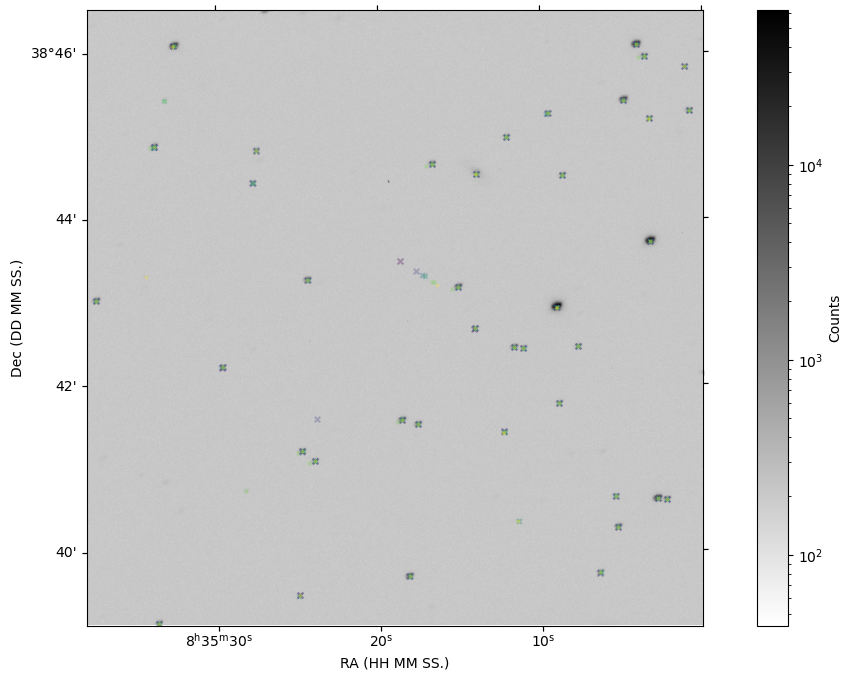

Culling Stationary Sources: 100%|██████████| 6/6 [00:00<00:00, 75.82it/s]

[3, 3, 4, 1, 10, 7]


In [22]:
from tqdm import tqdm
from astropy.coordinates import SkyCoord
from astropy.time import Time
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture
import astropy.units as u
import numpy as np

all_sources = []
all_times = []

obs = list(astro.observations)[3]

fig = plt.figure(figsize=(14, 8.0))
ax = fig.add_subplot(projection=obs.wcs)

im = ax.imshow(obs.data, cmap="gray_r", norm='log')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Counts')
ax.set_xlabel("RA (HH MM SS.)")
ax.set_ylabel("Dec (DD MM SS.)")

cmap = plt.cm.viridis
n = len(astro.observations)

for i, obs in tqdm(enumerate(astro.observations), total=len(astro.observations), desc="Collecting Sources"):
    x_1 = obs.sources["xcentroid"].astype(np.float32)
    y_1 = obs.sources["ycentroid"].astype(np.float32)
    sc = SkyCoord([obs.px_to_eq(x, y) for x, y in zip(x_1, y_1)])

    color = cmap(i / max(n - 1, 1))

    ax.scatter(
        sc.ra.deg,
        sc.dec.deg,
        s=(n-i)*3,
        marker="x",
        alpha=0.3,
        color=color,
        label=obs.name,
        transform=ax.get_transform('world')
    )

    all_sources.append(sc)
    all_times.append(Time(obs.header.get("DATE-OBS"), scale='utc'))


ax.set_aspect("equal")
ax.relim()
ax.autoscale_view()
plt.show()


tol = 0.5 * u.arcsec

for i in tqdm(range(len(all_sources)), desc="Culling Stationary Sources"):
    ref = all_sources[i]

    ref_is_static = np.zeros(len(ref), dtype=bool)

    for k in range(len(all_sources)):
        if k == i: continue

        sc = all_sources[k]

        idx_ref, idx_sc, sep2d, _ = sc.search_around_sky(ref, tol)

        ref_is_static[idx_ref] = True

        keep_sc = np.ones(len(sc), dtype=bool)
        keep_sc[idx_sc] = False
        all_sources[k] = sc[keep_sc]

    all_sources[i] = ref[~ref_is_static]

print([len(sources) for sources in all_sources])

[<SkyCoord (ICRS): (ra, dec) in deg
    [(128.87387858, 38.70355901), (128.80887312, 38.7111203 ),
     (128.82795362, 38.7248026 )]>, <SkyCoord (ICRS): (ra, dec) in deg
    [(128.85346655, 38.68658691), (128.84939854, 38.69327832),
     (128.82384463, 38.72273   )]>, <SkyCoord (ICRS): (ra, dec) in deg
    [(128.82573629, 38.66167777), (128.78994011, 38.75413319),
     (128.82235157, 38.7220352 ), (128.85436581, 38.65774182)]>, <SkyCoord (ICRS): (ra, dec) in deg
    [(128.82143903, 38.7216839)]>, <SkyCoord (ICRS): (ra, dec) in deg
    [(128.81453932, 38.71911886), (128.82853747, 38.69259739),
     (128.89202091, 38.74760964), (128.82111026, 38.7438425 ),
     (128.81970731, 38.720523  ), (128.76634806, 38.76538453),
     (128.85151412, 38.68441001), (128.85443188, 38.68637604),
     (128.81920876, 38.72043868), (128.86771289, 38.67881223)]>, <SkyCoord (ICRS): (ra, dec) in deg
    [(128.78783353, 38.71529192), (128.88609414, 38.76792653),
     (128.76371011, 38.75302666), (128.81844996,

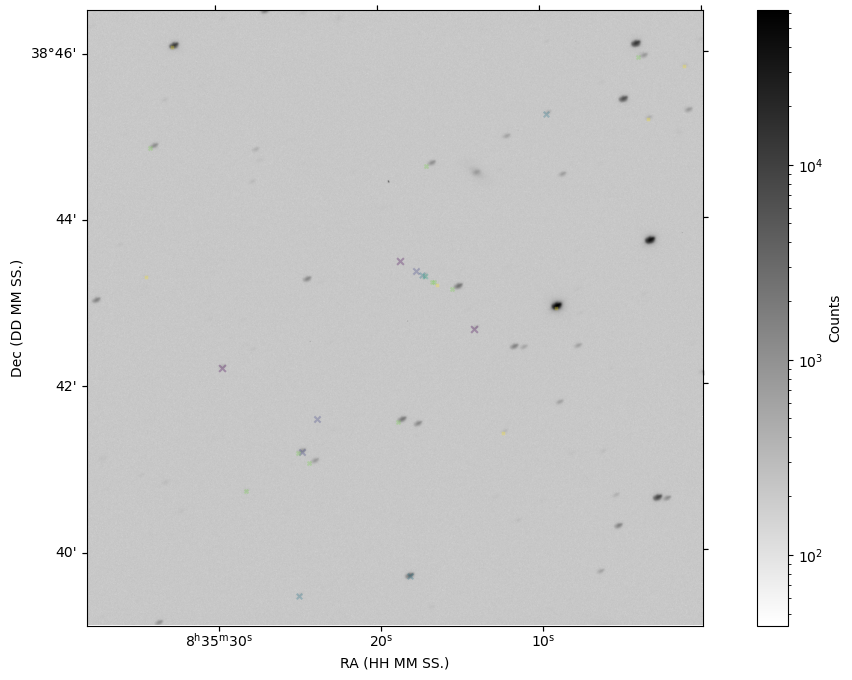

In [23]:
obs = list(astro.observations)[3]

fig = plt.figure(figsize=(14, 8.0))
ax = fig.add_subplot(projection=obs.wcs)

im = ax.imshow(obs.data, cmap="gray_r", norm='log')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Counts')
ax.set_xlabel("RA (HH MM SS.)")
ax.set_ylabel("Dec (DD MM SS.)")

cmap = plt.cm.viridis
n = len(all_sources)
print(all_sources)

for i, sources in enumerate(all_sources):
    print(sources)
    color = cmap(i / max(n - 1, 1))

    ax.scatter(
        sources.ra.deg,
        sources.dec.deg,
        s=(n-i) * 4,
        marker="x",
        color=color,
        alpha=0.3,
        label=obs.name,
        transform=ax.get_transform('world')
    )

In [19]:
def validity_check(chain, tol):
    if len(chain) <= 2:
        # is a source or pair. Always return True
        return True

    # define list indices for obs n-2, n-1, and n
    nm2 = len(chain) - 3
    nm1 = len(chain) - 2
    n = len(chain) - 1

    # get d/dt from n-2 to n-1
    delta_T21 = (all_times[nm1] - all_times[nm2]).to(u.second)

    dra12, ddec12 = (chain[nm2].spherical_offsets_to(chain[nm1]))

    dra12_dt = dra12 / delta_T21
    ddec12_dt = ddec12 / delta_T21

    # get deltaT for n-1 to n
    delta_T23 = (all_times[n] - all_times[nm1]).to(u.second)

    # predict new ra, dec
    pred_delta_ra = dra12_dt * delta_T23
    pred_delta_dec = ddec12_dt * delta_T23

    # make a skycoord with the predicted ra, dec offsets
    pred_sc = chain[nm1].spherical_offsets_by(pred_delta_ra, pred_delta_dec)

    # get angular sep from true coord to pred coord, return True if small enough
    offset = pred_sc.separation(chain[n])
    if offset < tol:
        return True

    # Failed. Return False.
    return False


In [ ]:
c1 = all_sources[0][0]
t1 = all_times[0]

c2 = c1.spherical_offsets_by(0.944*u.deg, 1.1*u.deg)
t2 = t1 + 1*u.second

c3 = c2.spherical_offsets_by(1.022*u.deg, 0.974*u.deg)
t3 = t2 + 1*u.second

print(c1, c2, c3)

all_times = [t1, t2, t3]
worked = validity_check([c1, c2, c3], tol=0.8*u.deg)

print(worked)

<SkyCoord (ICRS): (ra, dec) in deg
    (115.17737831, 9.95689527)> <SkyCoord (ICRS): (ra, dec) in deg
    (116.1390529, 11.05552549)> <SkyCoord (ICRS): (ra, dec) in deg
    (117.18384416, 12.0277387)>
(<Angle 0.944 deg>, <Angle 1.1 deg>)
0.9439999999938277 deg / s 1.0999999999927932 deg / s
0d08m53.45641067s
True


In [24]:
# initialize chains with all sources in first observation
queue = [[source] for source in all_sources[0]]

# possible successes
success = []

# continue until nothing left in chains
while queue:

    # get 'oldest' chain on the stack
    curr = queue.pop(0)

    print(len(queue), len(curr))

    # add new combinations to the queue if they pass filter
    for source in all_sources[len(curr)]:
        new_chain = curr + [source]

        valid = validity_check(new_chain, tol=30*u.arcsec)

        if valid and len(new_chain) == len(all_sources):
            # completed chain that is valid
            success.append(new_chain)
        elif valid:
            queue.append(new_chain)

if not success:
    print("Searched all possible chains and found no potential targets. Perhaps increase tolerance?")
else:
    print(success)

2 1
4 1
6 1
8 2
7 2
6 2
5 2
4 2
3 2
2 2
1 2
0 2
Searched all possible chains and found no potential targets. Perhaps increase tolerance?


c:\Users\truji\anaconda3\envs\astro\Lib\site-packages\astropy\units\quantity.py:659: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
c:\Users\truji\anaconda3\envs\astro\Lib\site-packages\astropy\units\quantity.py:659: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


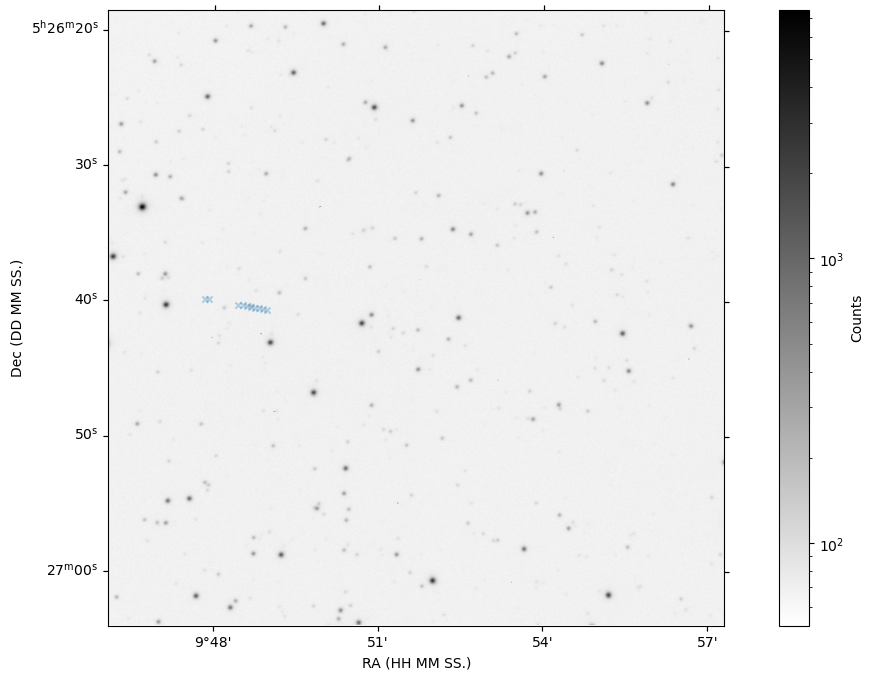

In [11]:
obs = list(astro.observations.values())[5]

fig = plt.figure(figsize=(14, 8.0))
ax = fig.add_subplot(projection=obs.wcs)

im = ax.imshow(obs.data, cmap="gray_r", norm='log')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Counts')
ax.set_xlabel("RA (HH MM SS.)")
ax.set_ylabel("Dec (DD MM SS.)")

for chain in success:
    sc = SkyCoord(chain)

    ax.scatter(
        sc.ra.deg,
        sc.dec.deg,
        s=20,
        marker="x",
        alpha=0.3,
        label=name,
        transform=ax.get_transform('world')
    )

In [3]:
import astropy.units as u

positions = astro.track_objects(["2012PQ28"], rad=10, make_plots=True, stationary_error=1*u.arcsec, prediction_error=3*u.arcsec)

Tracking:   0%|          | 0/20 [00:00<?, ?it/s]


AttributeError: 'Observation' object has no attribute 'fits_plot'